# Comparison with Marbach 2021 article

## Preambule

In [1]:
from brownpy.gpu_sim import Universe
import brownpy.topology as Top
from brownpy.utils import prefix, unwrap
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/axes_grid1/inset_locator_demo.html
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import numpy as np
from threading import Thread
from pathlib import Path
import time
import pandas as pd
from tqdm.notebook import tqdm
plt.style.use('default')
import cupy as cp


In [7]:
# Diffusion coefficient
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

"""
┃         ┃   ┃         ┃      ↑  
┃         ┃   ┃         ┃      │
┃         ┗━━━┛         ┃      │
┃                       ┃ ↕ Hc │ 2 H
┃         ┏━━━┓         ┃      │
┃         ┃   ┃         ┃      │
┃         ┃   ┃         ┃      ↓
 ←-------→ ←-→ ←-------→
     L      Lc     L
"""
# Conversion into my notation
Hc = 1E2 # A (10nm) - Channel width
L = 250*Hc # Channel depth
H_factor = 1
H = H_factor*Hc # Distance between channel
ar_factor = 100
Lc = ar_factor*Hc # Channel length

# Timestep 
dt = int(0.05*Hc**2/D)
N = 2*1024
print(f'dt = {dt:.2e} fs = {prefix(dt*1E-15)}s')

Nsteps = int(1.5*1E6/0.05) 
print(f"Number of steps : {Nsteps:.2e} = {prefix(dt*Nsteps*1E-15)}s")


top = Top.ElasticChannel2(Hc=Hc, Lc=Lc, 
                          H=H, L=L)
u=Universe(N=N, top=top, D=D, dt=dt,
           output_path=f'./4/channel/{H_factor}_{ar_factor}',
           overwrite=True)
# data = {}
# for factor in [0.04,0.10,0.20,0.40,0.95]:
#     print('#################################')
#     print(factor)
#     data[factor] = {}
#     Lm = R/factor # A - Reservoir height
#     top = Top.ElasticPore1(L=L, Lm=Lm, R=R)
#     u = Universe(N=N, top=top, D=D, dt=dt,
#                 output_path=f'pore_{factor:.2f}'.replace('.','_'))
#     u.run(1_000_000, freq_dumps=100);
#     data[factor]['u'] = u
#     u.run(Nsteps)

#     region_0 = u[1]['left'].astype(np.int16) # Number of particles in left part
#     DeltaN = (N-region_0) - region_0 # Number difference : N_R - N_L 
#     data[factor]['DeltaN'] = DeltaN

    # Compute <DeltaN(t)²>
    # signal = DeltaN[::sampling]
    # n_difference = np.zeros_like(intervals)
    # signal_d = cp.asarray(signal)
    # for i, inteval in tqdm(list(enumerate(intervals))):
    #     zeros_d = cp.asarray(np.ones(inteval)/ float(inteval))
    #     mean_d = cp.convolve(signal_d, zeros_d, 'valid')
    #     mean2_d = cp.convolve(signal_d**2, zeros_d, 'valid')
    #     var_d = mean2_d-mean_d**2
    #     n_difference[i] = (cp.mean(var_d)).get()
    # del signal_d, zeros_d, mean_d, mean2_d, var_d

dt = 3.33e+06 fs = 3.33 ns
Number of steps : 3.00e+07 = 100 ms


In [47]:
%matplotlib qt
# %matplotlib inline 

fig, ax = u.plot(scatter_kwargs={'s':1})
# ax.set_xlim(-H, H)
ax.set_xlim(-Lc*1.2, Lc*1.2)
print(top)

ElasticChannel2
version 0.0.1
L=25000.0
H=100.0
Lc=10000.0
Hc=100.0



In [18]:
u.run(10000, freq_dumps=100)

100%|██████████| 10000/10000 [00:03<00:00, 2700.60it/s, total=33.3 µs]

With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 250 fs
Engine: 2.8 ns
Transfert to RAM: 325 ps
Total: 3.12 ns
------------------------------------------
CPU time per step and per particles:
Total: 181 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 54.4  s


Reading trajectory ...
... Done
left  read
right  read


(-2500.0, 2500.0)

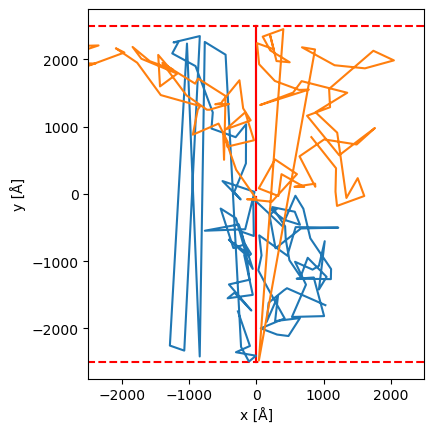

In [32]:
data = u[0]
traj = data['trajectory']
fig, ax  = top.plot()
indices = np.argsort(np.sum(traj[:,0]>0, axis=1)*np.sum(traj[:,0]<0, axis=1))[::-1][:2]
for i in indices:
    ax.plot(traj[i,0], traj[i,1])
ax.set_xlim(-H, H)

In [7]:
u.run(Nsteps)

100%|██████████| 300000000/300000000 [21:11<00:00, 235971.17it/s, total=1  s]

With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 50.2 fs
Engine: 2.04 ns
Transfert to RAM: 11.9 ps
Total: 2.05 ns
------------------------------------------
CPU time per step and per particles:
Total: 2.07 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 621 ms


In [8]:
data= u[1]

left  read
right  read


In [9]:
DeltaN = (data['right'] - data['left']).astype(np.int16)
insideN = N-(data['right']+data['left'])


(0.0, 100000.0)

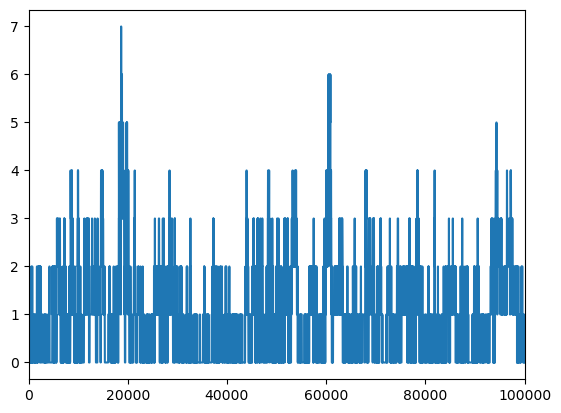

In [27]:
plt.plot(insideN[:100000])
plt.xlim(0,100000)

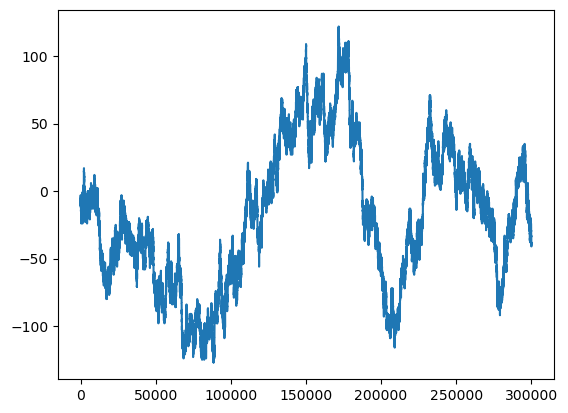

In [21]:
plt.plot(DeltaN[::100])

In [10]:
df = pd.DataFrame(DeltaN)
intervals = np.logspace(-1,6,40) # in Hc²/D
intervals_dt = np.int64(intervals*Hc**2/D/dt) # In timesteps unit
n_difference = []
for interval in tqdm(intervals_dt, leave=False):
    n_difference.append(df.rolling(interval).var().mean()[0])
n_difference = np.array(n_difference)

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

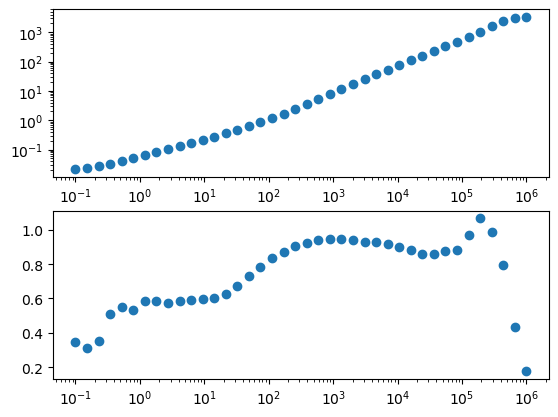

In [35]:
fig, axes = plt.subplots(2)
ax = axes[0]
ax.scatter(intervals, n_difference)
ax.set_yscale('log')

ax = axes[1]
ax.scatter(intervals, np.gradient(np.log(n_difference))/np.gradient(np.log((intervals))))

for ax in axes:
    ax.set_xscale('log')

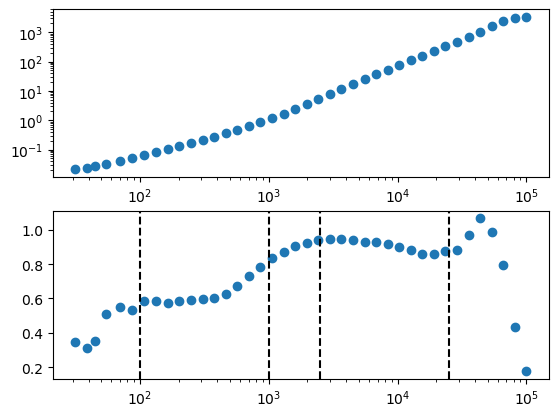

In [42]:
fig, axes = plt.subplots(2)
ax = axes[0]
ax.scatter(np.sqrt(intervals_dt*dt*D), n_difference)
ax.set_yscale('log')

ax = axes[1]
ax.scatter(np.sqrt(intervals_dt*dt*D), np.gradient(np.log(n_difference))/np.gradient(np.log((intervals))))
ax.axvline(Hc, c='k', ls='--')
ax.axvline(Lc, c='k', ls='--')
ax.axvline(H , c='k', ls='--')
ax.axvline(L , c='k', ls='--')
for ax in axes:
    ax.set_xscale('log')


In [55]:
 f= h5py.File('./4/channel/1_0.hdf5', 'r')


In [51]:
f.keys()

<KeysViewHDF5 []>

In [52]:
f.close()

In [49]:
output_path

WindowsPath('4/channel/1_5.h5py')

In [5]:

def compute_rolling_var(intervals_dt, DeltaN, insideN, file_path):
    
    df = pd.DataFrame(DeltaN)
    DeltaN_rv = []
    for interval in intervals_dt:
        DeltaN_rv.append(df.rolling(interval).var().mean()[0])
    DeltaN_rv = np.array(DeltaN_rv)

    insideN = N-(data['right']+data['left'])
    df = pd.DataFrame(insideN)
    insideN_rv = []
    for interval in intervals_dt:
        insideN_rv.append(df.rolling(interval).var().mean()[0])
    insideN_rv = np.array(insideN_rv)
    with h5py.File(file_path, 'a') as f:
        rungrp = f['run']['0']
        rungrp.create_dataset('intervals_dt', data = intervals_dt)
        rungrp.create_dataset('DeltaN_rv', data = DeltaN_rv)
        rungrp.create_dataset('insideN_rv', data = insideN_rv)

# Diffusion coefficient
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

"""
┃         ┃   ┃         ┃      ↑  
┃         ┃   ┃         ┃      │
┃         ┗━━━┛         ┃      │
┃                       ┃ ↕ Hc │ 2 H
┃         ┏━━━┓         ┃      │
┃         ┃   ┃         ┃      │
┃         ┃   ┃         ┃      ↓
 ←-------→ ←-→ ←-------→
     L      Lc     L
"""
# Conversion into my notation
Hc = 1E2 # A (10nm) - Channel width
L = 250*Hc # Channel depth

# Timestep 
dt = int(0.05*Hc**2/D)
N = 2*1024
print(f'dt = {dt:.2e} fs = {prefix(dt*1E-15)}s')

Nsteps = int(1.5*1E6/0.05) * 0.1
print(f"Number of steps : {Nsteps:.2e} = {prefix(dt*Nsteps*1E-15)}s")

# Time interval for computing rolling variance
intervals = np.logspace(-1,6,40) # in Hc²/D
intervals_dt = np.int64(intervals*Hc**2/D/dt) # In timesteps unit

threads = []
# H_factors = H/Hc
H_factors = [1, 2, 10, 25, 100]
# ar_factor = Lc/Hc
ar_factors = [0, 1, 2, 5, 10, 100]
for H_factor in H_factors:
    for ar_factor in ar_factors:
        print('###############')
        print(f'{H_factor}_{ar_factor}')
        output_path=Path(f'./4/channel/{H_factor}_{ar_factor}.hdf5')
        if output_path.exists():
            continue
        
        H = H_factor*Hc # Distance between channel
        Lc = ar_factor*Hc # Channel length

        top = Top.ElasticChannel2(Hc=Hc, Lc=Lc, 
                                H=H, L=L)
        u=Universe(N=N, top=top, D=D, dt=dt,
                output_path=output_path,
                overwrite=True)
        u.run(Nsteps)
        time.sleep(1)
        
        data = u[0]
        DeltaN = (data['right'] - data['left']).astype(np.int16)
        insideN = N-(data['right']+data['left'])
        
        thread = Thread(target=compute_rolling_var, 
                        args=(intervals_dt, DeltaN, insideN, output_path))
        thread.start()
        
for thread in threads:
    thread.join()

dt = 3.33e+06 fs = 3.33 ns
Number of steps : 3.00e+06 = 10 ms
###############
1_0


100%|██████████| 3000000/3000000 [00:19<00:00, 150041.06it/s, total=10 ms]


With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 48.2 fs
Engine: 2.81 ns
Transfert to RAM: 12.4 ps
Total: 2.82 ns
------------------------------------------
CPU time per step and per particles:
Total: 3.26 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 977 ms


left  read
right  read
###############
1_1


100%|██████████| 3000000/3000000 [00:21<00:00, 142481.46it/s, total=10 ms]


With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 47.8 fs
Engine: 2.85 ns
Transfert to RAM: 14.1 ps
Total: 2.86 ns
------------------------------------------
CPU time per step and per particles:
Total: 3.43 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 1.03  s


left  read
right  read
###############
1_2


KeyboardInterrupt: 

In [4]:
output_folder_path=Path(f'./4/channel/1')

In [5]:
data_rv = {}
for file_path in output_folder_path.glob('*.out'):
    data_rv[file_path.stem] = np.genfromtxt(file_path, delimiter=',')

Text(0.5, 0, '$H_c^2/D$')

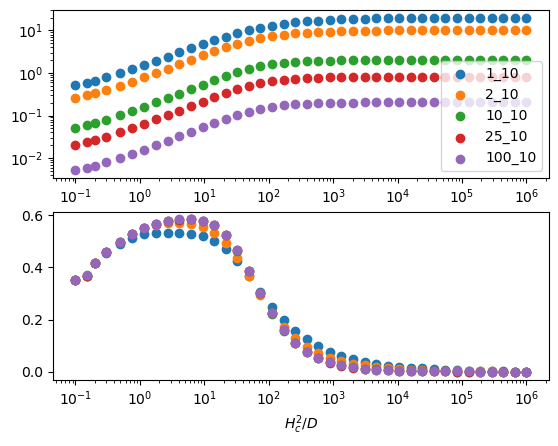

In [16]:
H_factors = [1, 2, 10, 25, 100]
ar_factors = [10]

fig, axes = plt.subplots(2)
for H_factor in H_factors:
    for ar_factor in ar_factors:
        intervals_dt, DeltaN_rv, insideN_rv = data_rv[f'{H_factor}_{ar_factor}'].T
        intervals = intervals_dt*dt*D/Hc**2
        axes[0].scatter(intervals, insideN_rv, 
                        label=f'{H_factor}_{ar_factor}')
        axes[1].scatter(intervals, np.gradient(np.log(insideN_rv))/np.gradient(np.log((intervals))),
                        label=f'{H_factor}_{ar_factor}')
axes[0].legend()
axes[0].set_yscale('log')
for ax in axes:
    ax.set_xscale('log')
axes[1].set_xlabel('$H_c^2/D$')

Text(0.5, 0, '$H_c^2/D$')

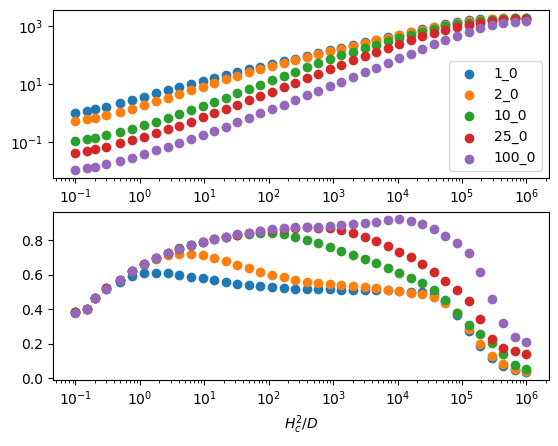

In [8]:
H_factors = [1, 2, 10, 25, 100]
ar_factors = [0]

fig, axes = plt.subplots(2)
for H_factor in H_factors:
    for ar_factor in ar_factors:
        intervals_dt, DeltaN_rv, insideN_rv = data_rv[f'{H_factor}_{ar_factor}'].T
        intervals = intervals_dt*dt*D/Hc**2
        axes[0].scatter(intervals, DeltaN_rv, 
                        label=f'{H_factor}_{ar_factor}')
        axes[1].scatter(intervals, np.gradient(np.log(DeltaN_rv))/np.gradient(np.log((intervals))),
                        label=f'{H_factor}_{ar_factor}')
axes[0].legend()
axes[0].set_yscale('log')
for ax in axes:
    ax.set_xscale('log')
axes[1].set_xlabel('$H_c^2/D$')

Text(0.5, 0, '$H_c^2/D$')

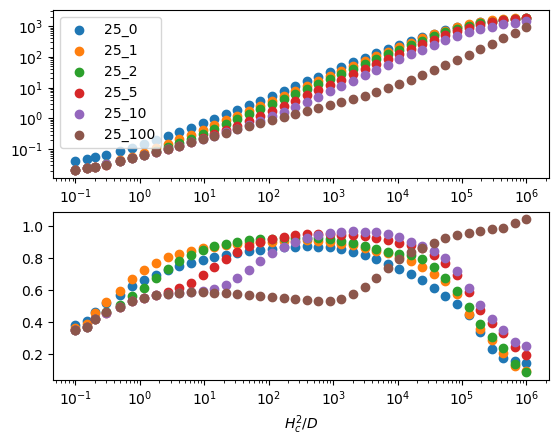

In [9]:
H_factors = [25]
ar_factors = [0, 1, 2, 5, 10, 100]

fig, axes = plt.subplots(2)
for H_factor in H_factors:
    for ar_factor in ar_factors:
        intervals_dt, DeltaN_rv, insideN_rv = data_rv[f'{H_factor}_{ar_factor}'].T
        intervals = intervals_dt*dt*D/Hc**2
        axes[0].scatter(intervals, DeltaN_rv, 
                        label=f'{H_factor}_{ar_factor}')
        axes[1].scatter(intervals, np.gradient(np.log(DeltaN_rv))/np.gradient(np.log((intervals))),
                        label=f'{H_factor}_{ar_factor}')
axes[0].legend()
axes[0].set_yscale('log')
for ax in axes:
    ax.set_xscale('log')
axes[1].set_xlabel('$H_c^2/D$')

<ipython-input-13-0f241483bd31>:11: RuntimeWarning: divide by zero encountered in true_divide
  axes[1].scatter(intervals/ar_factor**2, np.gradient(np.log(DeltaN_rv))/np.gradient(np.log((intervals))),


Text(0.5, 0, '$H_c^2/D$')

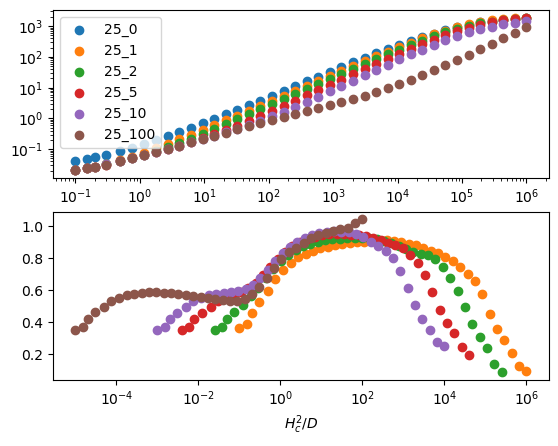

In [13]:
H_factors = [25]
ar_factors = [0, 1, 2, 5, 10, 100]

fig, axes = plt.subplots(2)
for H_factor in H_factors:
    for ar_factor in ar_factors:
        intervals_dt, DeltaN_rv, insideN_rv = data_rv[f'{H_factor}_{ar_factor}'].T
        intervals = intervals_dt*dt*D/Hc**2
        axes[0].scatter(intervals, DeltaN_rv, 
                        label=f'{H_factor}_{ar_factor}')
        axes[1].scatter(intervals/ar_factor**2, np.gradient(np.log(DeltaN_rv))/np.gradient(np.log((intervals))),
                        label=f'{H_factor}_{ar_factor}')
axes[0].legend()
axes[0].set_yscale('log')
for ax in axes:
    ax.set_xscale('log')
axes[1].set_xlabel('$H_c^2/D$')